In [5]:
# Import Required Libraries for Crypto Factor Analysis with Alphalens
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import alphalens
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import requests
import time
import json
import ccxt
import os
from concurrent.futures import ThreadPoolExecutor, as_completed

# Configure plotting
%matplotlib inline
plt.style.use('default')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (20, 16)
plt.rcParams['font.size'] = 12
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

print("✅ All libraries imported successfully!")
print("📊 Ready for crypto factor analysis with Alphalens")
print("🚀 Using real_time crypto data fetching strategy")

✅ All libraries imported successfully!
📊 Ready for crypto factor analysis with Alphalens
🚀 Using real_time crypto data fetching strategy


In [6]:
# Crypto Data Fetching Functions (Direct from Exchanges)

def fetch_crypto_data_from_exchanges(cryptocurrencies=['BTC', 'ETH', 'SOL', 'ADA', 'DOT', 'LINK', 'MATIC', 'AVAX'], 
                                   exchanges=['okx'], 
                                   timeframe='1h', 
                                   days_back=365):
    """
    Fetch cryptocurrency data directly from exchanges using ccxt.
    
    Args:
        cryptocurrencies: List of cryptocurrencies to fetch
        exchanges: List of exchanges to use
        timeframe: Data timeframe ('1h', '4h', '1d')
        days_back: Number of days of historical data to fetch
    
    Returns:
        Dictionary with crypto data organized by crypto and exchange
    """
    print(f"🔄 Fetching crypto data directly from exchanges...")
    print(f"🪙 Cryptocurrencies: {cryptocurrencies}")
    print(f"📊 Exchanges: {exchanges}")
    print(f"⏱️ Timeframe: {timeframe}")
    print(f"📅 Days back: {days_back}")
    
    crypto_data = {}
    
    # Initialize exchanges
    exchange_instances = {}
    for exchange_name in exchanges:
        try:
            if exchange_name == 'binance':
                exchange_instances[exchange_name] = ccxt.binance({
                    'enableRateLimit': True,
                    'sandbox': False
                })
            elif exchange_name == 'okx':
                exchange_instances[exchange_name] = ccxt.okx({
                    'enableRateLimit': True,
                    'sandbox': False
                })
            elif exchange_name == 'bybit':
                exchange_instances[exchange_name] = ccxt.bybit({
                    'enableRateLimit': True,
                    'sandbox': False
                })
            print(f"✅ {exchange_name.upper()} exchange initialized")
        except Exception as e:
            print(f"❌ Failed to initialize {exchange_name}: {e}")
    
    # Calculate time range
    end_time = datetime.now()
    start_time = end_time - timedelta(days=days_back)
    since = int(start_time.timestamp() * 1000)
    
    print(f"📅 Fetching data from {start_time.date()} to {end_time.date()}")
    
    # Fetch data for each cryptocurrency and exchange
    for crypto in cryptocurrencies:
        crypto_data[crypto] = {}
        print(f"\n📈 Fetching {crypto} data...")
        
        for exchange_name, exchange in exchange_instances.items():
            print(f"  📊 From {exchange_name.upper()}...")
            
            try:
                # Define symbol (most exchanges use this format)
                symbol = f'{crypto}/USDT'
                
                # Check if symbol exists on exchange
                markets = exchange.load_markets()
                if symbol not in markets:
                    print(f"    ⚠️ {symbol} not available on {exchange_name}")
                    continue
                
                # Fetch OHLCV data in chunks
                all_ohlcv = []
                current_since = since
                max_limit = 1000  # Most exchanges limit to 1000 candles per request
                
                while True:
                    try:
                        ohlcv = exchange.fetch_ohlcv(symbol, timeframe, current_since, max_limit)
                        
                        if not ohlcv:
                            break
                        
                        all_ohlcv.extend(ohlcv)
                        
                        # Update timestamp for next batch
                        current_since = ohlcv[-1][0] + 1
                        
                        # Progress indicator
                        current_date = datetime.fromtimestamp(ohlcv[-1][0] / 1000)
                        print(f"    📊 Progress: {current_date.strftime('%Y-%m-%d')} ({len(all_ohlcv)} records)", end='\r')
                        
                        # Stop if we've reached current time
                        if current_date >= end_time:
                            break
                        
                        # Rate limiting
                        time.sleep(exchange.rateLimit / 1000)
                        
                    except Exception as e:
                        print(f"    ❌ Error fetching batch: {e}")
                        break
                
                # Convert to DataFrame
                if all_ohlcv:
                    df = pd.DataFrame(all_ohlcv, columns=['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])
                    df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='ms')
                    df.set_index('Timestamp', inplace=True)
                    
                    # Remove duplicates and sort
                    df = df.drop_duplicates().sort_index()
                    
                    # Filter to requested date range
                    df = df[(df.index >= start_time) & (df.index <= end_time)]
                    
                    # Store data
                    crypto_data[crypto][f'{exchange_name}_spot'] = df
                    print(f"    ✅ {crypto} from {exchange_name}: {len(df)} records")
                else:
                    print(f"    ❌ No data retrieved for {crypto} from {exchange_name}")
                    
            except Exception as e:
                print(f"    ❌ Failed to fetch {crypto} from {exchange_name}: {e}")
    
    return crypto_data

def fetch_additional_crypto_data(additional_cryptos=['SOL', 'ADA', 'DOT', 'LINK'], exchanges=['binance']):
    """
    Fetch data for additional cryptocurrencies (legacy function - now integrated into main function).
    This function is kept for backward compatibility.
    """
    print(f"⚠️ This function is deprecated. Use fetch_crypto_data_from_exchanges() instead.")
    return fetch_crypto_data_from_exchanges(additional_cryptos, exchanges)

def calculate_crypto_factors(crypto_data, crypto_list=None, window_sizes=[20, 50, 100]):
    """
    Calculate multiple technical factors for crypto analysis.
    
    Args:
        crypto_data: Dictionary with crypto data
        crypto_list: List of cryptos to analyze (if None, use all)
        window_sizes: List of window sizes for moving averages
    
    Returns:
        Combined DataFrame with all factors for Alphalens analysis
    """
    if crypto_list is None:
        crypto_list = list(crypto_data.keys())
    
    print(f"📈 Calculating factors for: {crypto_list}")
    
    all_factor_data = []
    
    for crypto in crypto_list:
        if crypto not in crypto_data:
            print(f"❌ No data for {crypto}, skipping...")
            continue
        
        print(f"🔧 Processing {crypto} factors...")
        
        # Use primary data source (prefer spot data for consistency)
        primary_key = None
        for key_priority in ['binance_spot', 'okx_spot', 'bybit_spot', 'binance_futures', 'okx_futures']:
            if key_priority in crypto_data[crypto]:
                primary_key = key_priority
                break
        
        if primary_key is None:
            print(f"❌ No suitable data found for {crypto}")
            continue
        
        df = crypto_data[crypto][primary_key].copy()
        print(f"    📊 Using {primary_key} data: {len(df)} records")
        
        # Calculate base indicators
        close_prices = df['Close']
        
        # Focus on Z-score factors only (core of your trading strategy)
        factors_dict = {}
        
        for window in window_sizes:
            # Moving averages and standard deviation
            ma = close_prices.rolling(window=window).mean()
            rolling_std = close_prices.rolling(window=window).std()
            
            # Z-score factors (exactly like your strategy)
            factors_dict[f'zscore_{window}'] = (close_prices - ma) / rolling_std
            
        print(f"    📊 Calculated Z-score factors for windows: {window_sizes}")
        
        # Convert factors to long format for Alphalens
        for factor_name, factor_values in factors_dict.items():
            factor_df = pd.DataFrame({
                'date': factor_values.index,
                'asset': f'{crypto}_{factor_name}',
                'factor': factor_values.values
            }).dropna()
            
            if len(factor_df) > 0:
                all_factor_data.append(factor_df)
        
        print(f"    ✅ {crypto}: {len(factors_dict)} factors calculated")
    
    # Combine all factors
    if all_factor_data:
        combined_factors = pd.concat(all_factor_data, ignore_index=True)
        combined_factors = combined_factors.sort_values(['date', 'asset']).reset_index(drop=True)
        
        print(f"✅ Factor calculation complete!")
        print(f"📊 Total factor observations: {len(combined_factors):,}")
        print(f"📈 Unique factors: {combined_factors['asset'].nunique()}")
        
        return combined_factors
    else:
        print("❌ No factors calculated")
        return None

def prepare_crypto_prices_for_alphalens(crypto_data, crypto_list=None):
    """
    Prepare price data for Alphalens analysis.
    
    Args:
        crypto_data: Dictionary with crypto data
        crypto_list: List of cryptos to include
    
    Returns:
        DataFrame with prices (rows=dates, columns=assets)
    """
    if crypto_list is None:
        crypto_list = list(crypto_data.keys())
    
    print(f"💰 Preparing price data for: {crypto_list}")
    
    all_prices = {}
    
    for crypto in crypto_list:
        if crypto not in crypto_data:
            continue
        
        # Use primary data source (same priority as factor calculation)
        primary_key = None
        for key_priority in ['binance_spot', 'okx_spot', 'bybit_spot', 'binance_futures', 'okx_futures']:
            if key_priority in crypto_data[crypto]:
                primary_key = key_priority
                break
        
        if primary_key is None:
            continue
        
        df = crypto_data[crypto][primary_key]
        all_prices[crypto] = df['Close']
        print(f"  📊 {crypto}: Using {primary_key} data")
    
    if all_prices:
        prices_df = pd.DataFrame(all_prices)
        prices_df = prices_df.dropna(how='all')  # Remove rows where all assets are NaN
        
        print(f"✅ Price data prepared!")
        print(f"💰 Shape: {prices_df.shape}")
        print(f"📅 Date range: {prices_df.index.min()} to {prices_df.index.max()}")
        
        return prices_df
    else:
        print("❌ No price data prepared")
        return None

print("✅ Crypto data fetching and factor analysis functions defined!")
print("🔧 Functions available:")
print("  - fetch_crypto_data_from_exchanges(): Fetch crypto data directly from exchanges")
print("  - calculate_crypto_factors(): Calculate technical factors")
print("  - prepare_crypto_prices_for_alphalens(): Prepare price data")

✅ Crypto data fetching and factor analysis functions defined!
🔧 Functions available:
  - fetch_crypto_data_from_exchanges(): Fetch crypto data directly from exchanges
  - calculate_crypto_factors(): Calculate technical factors
  - prepare_crypto_prices_for_alphalens(): Prepare price data


In [7]:
# Fetch Crypto Data and Prepare Price & Factor Datasets
print("🚀 Starting Real-Time Crypto Factor Analysis")
print("="*60)

# Define cryptocurrencies to analyze - Top 10 "Real" Crypto (No Stablecoins)
target_cryptos = ['BTC', 'ETH', 'BNB', 'SOL', 'XRP', 'DOGE', 'ADA', 'AVAX', 'DOT', 'LINK']  # Top 10 real cryptocurrencies
target_exchanges = ['okx']  # Using only OKX for cleaner factor analysis

print(f"🪙 Target cryptocurrencies - Top 10 Real Crypto ({len(target_cryptos)}): {target_cryptos}")
print(f"📊 Target exchanges: {target_exchanges}")

# Fetch crypto data directly from exchanges
print(f"\n🔄 Fetching crypto data directly from exchanges...")

crypto_data = fetch_crypto_data_from_exchanges(
    cryptocurrencies=target_cryptos,
    exchanges=target_exchanges,
    timeframe='1d',  # Daily data for cleaner analysis
    days_back=365    # Full 1 year of daily data (365 data points)
)

# Display summary of fetched data
print(f"\n📊 CRYPTO DATA SUMMARY:")
print("="*50)

successful_cryptos = [crypto for crypto in crypto_data.keys() if crypto_data[crypto]]

print(f"🪙 Total cryptocurrencies requested: {len(target_cryptos)}")
print(f"🪙 Successfully fetched: {len(successful_cryptos)}")
print(f"📈 Available cryptos: {successful_cryptos}")

if len(successful_cryptos) < len(target_cryptos):
    failed_cryptos = set(target_cryptos) - set(successful_cryptos)
    print(f"❌ Failed to fetch: {list(failed_cryptos)}")

# =============================================================================
# 1. PREPARE PRICE DATA: DataFrame with rows=dates, columns=assets
# =============================================================================
print(f"\n💰 PREPARING PRICE DATA (rows=dates, columns=assets):")
print("="*60)

price_data = {}

for crypto in successful_cryptos:
    if crypto_data[crypto]:
        # Use first available exchange data
        exchange_key = list(crypto_data[crypto].keys())[0]
        df = crypto_data[crypto][exchange_key]
        price_data[crypto] = df['Close']
        print(f"📊 {crypto}: {len(df)} price records from {exchange_key}")

# Create price DataFrame: rows=dates, columns=assets
if price_data:
    prices_df = pd.DataFrame(price_data)
    prices_df = prices_df.dropna()  # Remove rows with any NaN values
    
    print(f"\n✅ PRICE DATA PREPARED!")
    print(f"📊 Shape: {prices_df.shape} (rows=dates, columns=assets)")
    print(f"📅 Date range: {prices_df.index.min()} to {prices_df.index.max()}")
    
    print(f"\n📈 FIRST 5 ROWS OF PRICE DATA:")
    print("-" * 50)
    display(prices_df.head())
else:
    print("❌ No price data prepared")
    prices_df = None

# =============================================================================
# 2. CALCULATE FACTORS: Multi-Index Pandas Series
# =============================================================================
print(f"\n🔧 CALCULATING Z-SCORE FACTORS (Multi-Index Series):")
print("="*60)

# Focus on appropriate window for daily data (20 days = ~1 month trading period)
window_sizes = [20]
factor_data_list = []

for crypto in successful_cryptos:
    if crypto_data[crypto]:
        # Use first available exchange data
        exchange_key = list(crypto_data[crypto].keys())[0]
        df = crypto_data[crypto][exchange_key]
        close_prices = df['Close']
        
        print(f"🔧 Processing {crypto} factors...")
        
        for window in window_sizes:
            if len(close_prices) >= window:
                # Calculate z-score factor
                ma = close_prices.rolling(window=window).mean()
                rolling_std = close_prices.rolling(window=window).std()
                zscore = (close_prices - ma) / rolling_std
                
                # Create multi-index entries for each valid observation
                for date, value in zscore.dropna().items():
                    factor_data_list.append({
                        'date': date,
                        'asset': crypto,
                        'factor_value': value
                    })
                
                print(f"  ✅ {crypto} zscore_{window}: {len(zscore.dropna())} valid observations")
            else:
                print(f"  ⚠️ {crypto}: Insufficient data for {window}-period calculation")

# Create Multi-Index Series for factors
if factor_data_list:
    factor_df = pd.DataFrame(factor_data_list)
    
    # Create multi-index: (date, asset) - only 2 levels as requested
    factor_series = factor_df.set_index(['date', 'asset'])['factor_value']
    factor_series.name = 'factor_value'
    
    print(f"\n✅ FACTOR DATA PREPARED!")
    print(f"📊 Total factor observations: {len(factor_series):,}")
    print(f"📈 Factor structure: Multi-Index Series (date, asset)")
    print(f"🎯 Unique assets: {factor_series.index.get_level_values('asset').nunique()}")
    print(f"🎯 Unique dates: {factor_series.index.get_level_values('date').nunique()}")
    
    print(f"\n📊 FIRST 10 OBSERVATIONS OF FACTOR DATA:")
    print("-" * 50)
    display(factor_series.head(10))
    
    print(f"\n📊 FACTOR DATA STRUCTURE INFO:")
    print("-" * 40)
    print(f"Index levels: {factor_series.index.names}")
    print(f"Data type: {type(factor_series)}")
    print(f"Value type: {factor_series.dtype}")
else:
    print("❌ No factor data calculated")
    factor_series = None

# =============================================================================
# 3. DATA VALIDATION & SUMMARY
# =============================================================================
print(f"\n🔍 DATA VALIDATION SUMMARY:")
print("="*50)

if prices_df is not None and factor_series is not None:
    # Check date alignment
    price_dates = set(prices_df.index)
    factor_dates = set(factor_series.index.get_level_values('date'))
    common_dates = price_dates & factor_dates
    
    print(f"📅 Price data dates: {len(price_dates):,}")
    print(f"📅 Factor data dates: {len(factor_dates):,}")
    print(f"📅 Common dates: {len(common_dates):,}")
    print(f"📊 Date overlap: {len(common_dates)/max(len(price_dates), len(factor_dates))*100:.1f}%")
    
    # Check asset alignment
    price_assets = set(prices_df.columns)
    factor_assets = set(factor_series.index.get_level_values('asset'))
    common_assets = price_assets & factor_assets
    
    print(f"🪙 Price data assets: {sorted(price_assets)}")
    print(f"🪙 Factor data assets: {sorted(factor_assets)}")
    print(f"🪙 Common assets: {sorted(common_assets)}")
    
    print(f"\n✅ DATASETS READY FOR ALPHALENS ANALYSIS!")
    print(f"💰 Price DataFrame: {prices_df.shape}")
    print(f"🔧 Factor Series: {len(factor_series):,} observations")
else:
    print("❌ Data preparation failed")

print(f"\n🎯 Next steps: Use these datasets for Alphalens factor analysis")

🚀 Starting Real-Time Crypto Factor Analysis
🪙 Target cryptocurrencies - Top 10 Real Crypto (10): ['BTC', 'ETH', 'BNB', 'SOL', 'XRP', 'DOGE', 'ADA', 'AVAX', 'DOT', 'LINK']
📊 Target exchanges: ['okx']

🔄 Fetching crypto data directly from exchanges...
🔄 Fetching crypto data directly from exchanges...
🪙 Cryptocurrencies: ['BTC', 'ETH', 'BNB', 'SOL', 'XRP', 'DOGE', 'ADA', 'AVAX', 'DOT', 'LINK']
📊 Exchanges: ['okx']
⏱️ Timeframe: 1d
📅 Days back: 365
✅ OKX exchange initialized
📅 Fetching data from 2024-08-01 to 2025-08-01

📈 Fetching BTC data...
  📊 From OKX...
    ✅ BTC from okx: 365 records5 records)

📈 Fetching ETH data...
  📊 From OKX...
    ✅ ETH from okx: 365 records5 records)

📈 Fetching BNB data...
  📊 From OKX...
    ✅ BNB from okx: 365 records5 records)

📈 Fetching SOL data...
  📊 From OKX...
    ✅ SOL from okx: 365 records5 records)

📈 Fetching XRP data...
  📊 From OKX...
    ✅ XRP from okx: 365 records5 records)

📈 Fetching DOGE data...
  📊 From OKX...
    ✅ DOGE from okx: 365 re

BTC      ETH    BNB     SOL     XRP     DOGE     ADA    AVAX  \
Timestamp                                                                      
2024-08-02  61489.9  2989.61  543.1  152.74  0.5606  0.11155  0.3636  23.607   
2024-08-03  60710.0  2903.79  529.5  142.52  0.5559  0.10813  0.3647  22.670   
2024-08-04  58160.1  2689.15  496.9  138.32  0.5229  0.10375  0.3440  21.250   
2024-08-05  54018.0  2419.73  464.3  129.78  0.4889  0.09434  0.3118  19.539   
2024-08-06  56022.0  2461.21  484.9  144.45  0.5060  0.09643  0.3310  20.898   

              DOT    LINK  
Timestamp                  
2024-08-02  5.126  11.920  
2024-08-03  5.043  11.683  
2024-08-04  4.687  10.887  
2024-08-05  4.197   9.486  
2024-08-06  4.510  10.066


🔧 CALCULATING Z-SCORE FACTORS (Multi-Index Series):
🔧 Processing BTC factors...
  ✅ BTC zscore_20: 346 valid observations
🔧 Processing ETH factors...
  ✅ ETH zscore_20: 346 valid observations
🔧 Processing BNB factors...
  ✅ BNB zscore_20: 346 valid observations
🔧 Processing SOL factors...
  ✅ SOL zscore_20: 346 valid observations
🔧 Processing XRP factors...
  ✅ XRP zscore_20: 346 valid observations
🔧 Processing DOGE factors...
  ✅ DOGE zscore_20: 346 valid observations
🔧 Processing ADA factors...
  ✅ ADA zscore_20: 346 valid observations
🔧 Processing AVAX factors...
  ✅ AVAX zscore_20: 346 valid observations
🔧 Processing DOT factors...
  ✅ DOT zscore_20: 346 valid observations
🔧 Processing LINK factors...
  ✅ LINK zscore_20: 346 valid observations

✅ FACTOR DATA PREPARED!
📊 Total factor observations: 3,460
📈 Factor structure: Multi-Index Series (date, asset)
🎯 Unique assets: 10
🎯 Unique dates: 346

📊 FIRST 10 OBSERVATIONS OF FACTOR DATA:
-----------------------------------------------

date        asset
2024-08-21  BTC      1.024485
2024-08-22  BTC      0.698270
2024-08-23  BTC      2.135081
2024-08-24  BTC      1.856181
2024-08-25  BTC      1.765880
2024-08-26  BTC      1.092542
2024-08-27  BTC     -0.540741
2024-08-28  BTC     -0.658106
2024-08-29  BTC     -0.460829
2024-08-30  BTC     -0.521356
Name: factor_value, dtype: float64


📊 FACTOR DATA STRUCTURE INFO:
----------------------------------------
Index levels: ['date', 'asset']
Data type: <class 'pandas.core.series.Series'>
Value type: float64

🔍 DATA VALIDATION SUMMARY:
📅 Price data dates: 365
📅 Factor data dates: 346
📅 Common dates: 346
📊 Date overlap: 94.8%
🪙 Price data assets: ['ADA', 'AVAX', 'BNB', 'BTC', 'DOGE', 'DOT', 'ETH', 'LINK', 'SOL', 'XRP']
🪙 Factor data assets: ['ADA', 'AVAX', 'BNB', 'BTC', 'DOGE', 'DOT', 'ETH', 'LINK', 'SOL', 'XRP']
🪙 Common assets: ['ADA', 'AVAX', 'BNB', 'BTC', 'DOGE', 'DOT', 'ETH', 'LINK', 'SOL', 'XRP']

✅ DATASETS READY FOR ALPHALENS ANALYSIS!
💰 Price DataFrame: (365, 10)
🔧 Factor Series: 3,460 observations

🎯 Next steps: Use these datasets for Alphalens factor analysis


Dropped 5.8% entries from factor data: 5.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Quantiles Statistics


min       max      mean       std  count  count %
factor_quantile                                                        
1               -3.607417  2.625674 -0.663799  1.158410    652     20.0
2               -3.188360  2.794515 -0.306823  1.184224    652     20.0
3               -2.691465  2.895454 -0.019190  1.203030    652     20.0
4               -2.200729  3.117072  0.336562  1.201374    652     20.0
5               -2.046726  3.637551  0.844777  1.226674    652     20.0

Returns Analysis


1D      5D     10D     20D
Ann. alpha                                      0.297   0.170   0.266   0.198
beta                                            0.049   0.081   0.190   0.131
Mean Period Wise Return Top Quantile (bps)      1.262   1.832  17.556  19.788
Mean Period Wise Return Bottom Quantile (bps) -16.643 -17.279 -15.508  -7.727
Mean Period Wise Spread (bps)                  17.905  18.937  32.706  27.644

<Figure size 2000x1600 with 0 Axes>

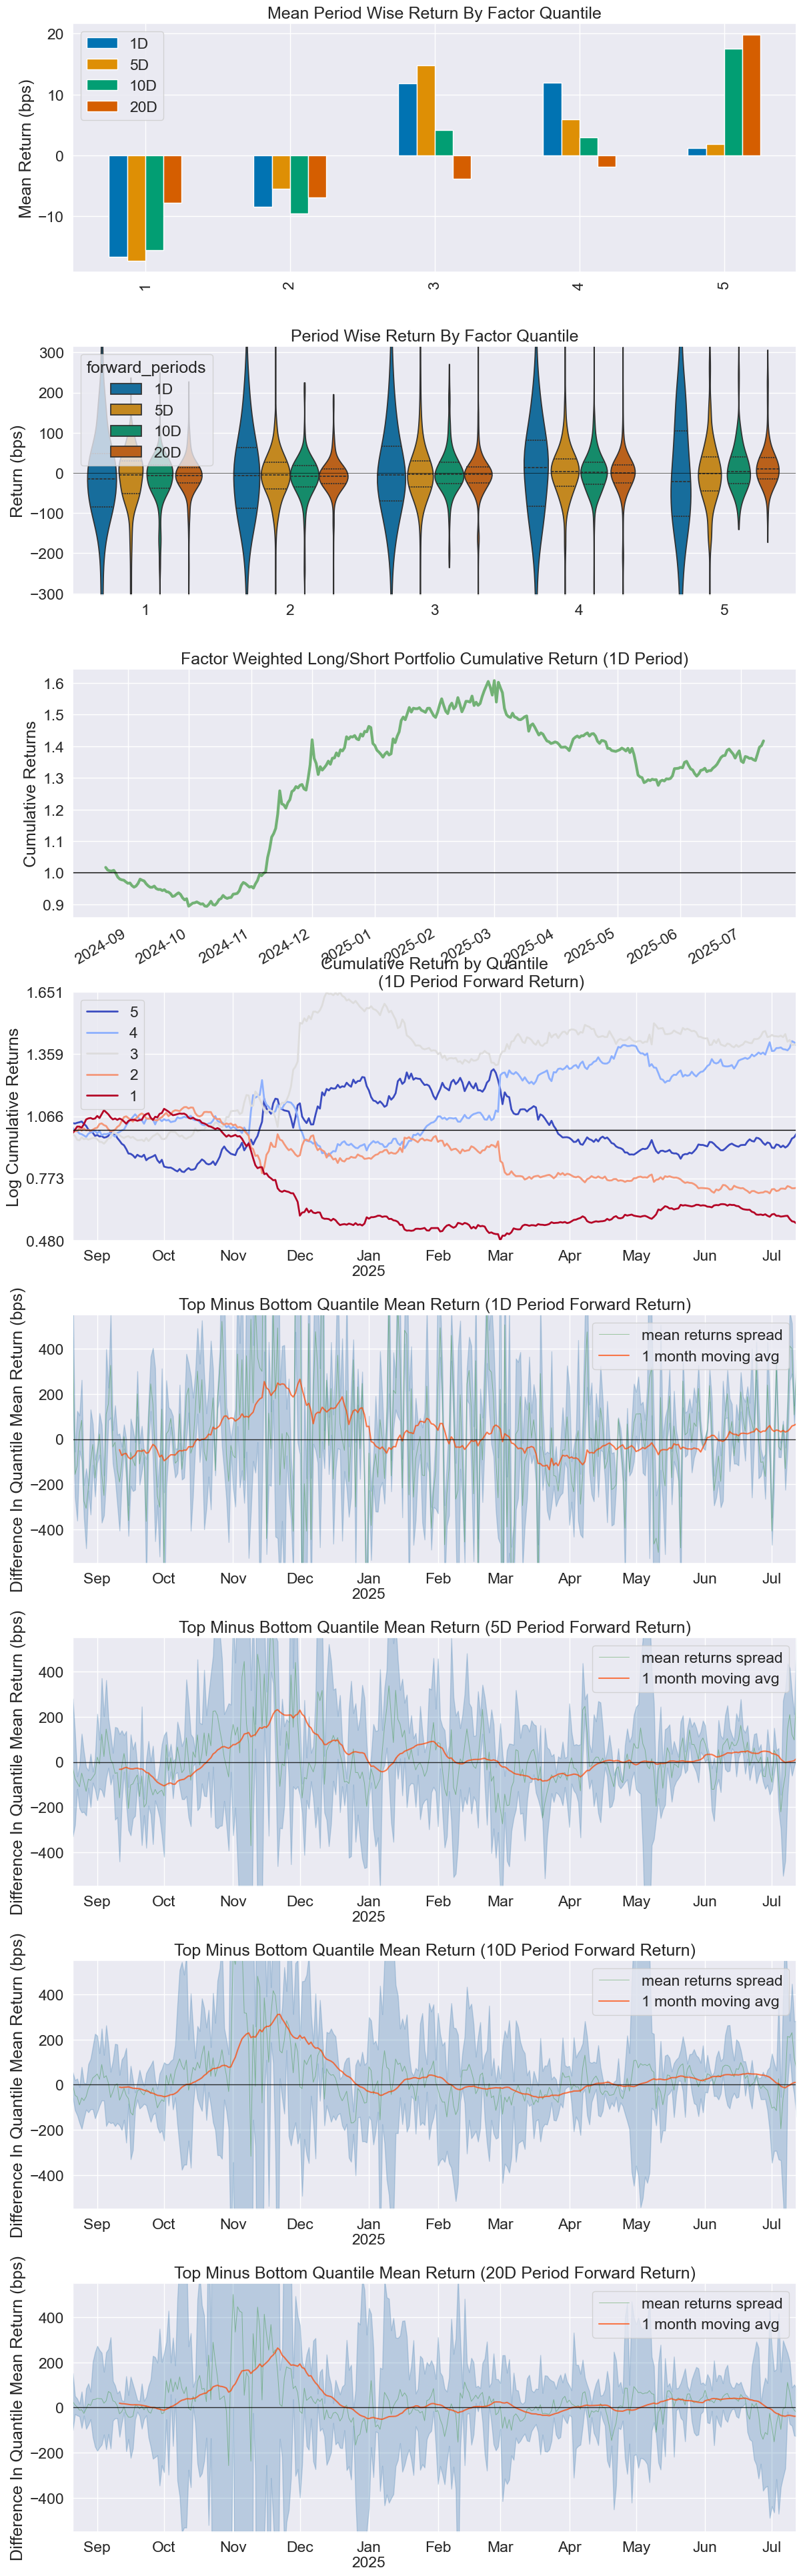

Information Analysis


1D     5D    10D    20D
IC Mean          -0.003  0.010  0.052  0.084
IC Std.           0.368  0.392  0.402  0.369
Risk-Adjusted IC -0.007  0.026  0.129  0.229
t-stat(IC)       -0.128  0.476  2.334  4.131
p-value(IC)       0.899  0.634  0.020  0.000
IC Skew           0.043 -0.067 -0.194 -0.055
IC Kurtosis      -0.603 -0.630 -0.882 -0.718

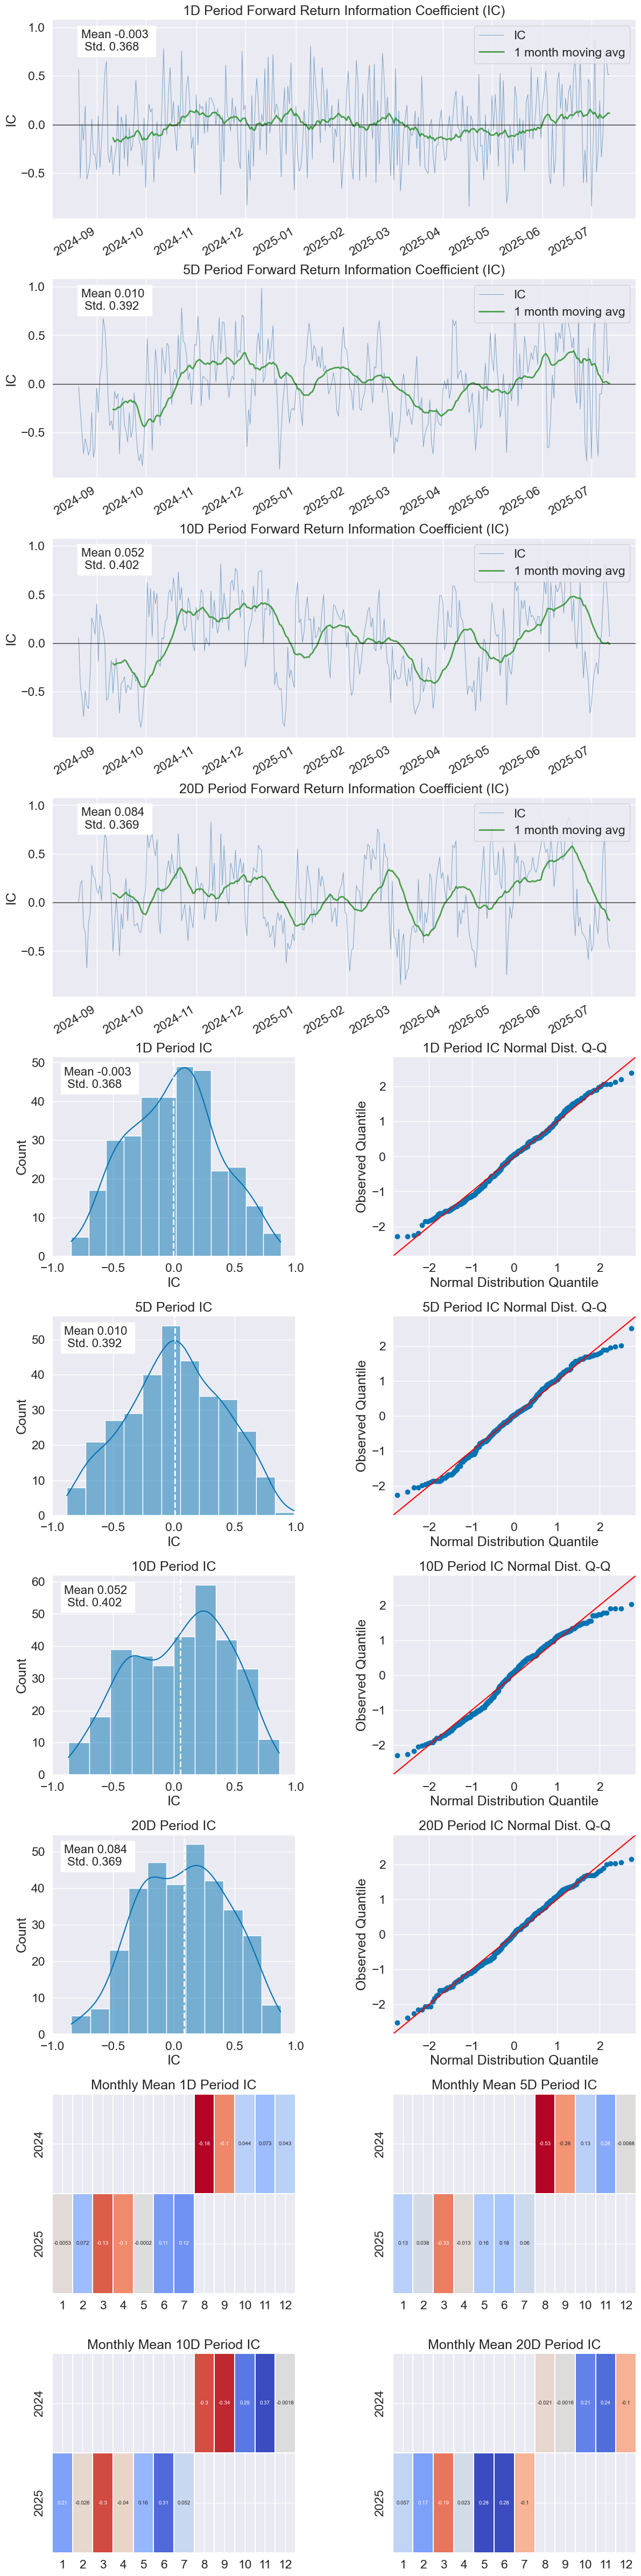

Turnover Analysis


1D     5D    10D    20D
Quantile 1 Mean Turnover   0.318  0.611  0.704  0.824
Quantile 2 Mean Turnover   0.525  0.710  0.782  0.806
Quantile 3 Mean Turnover   0.534  0.741  0.780  0.789
Quantile 4 Mean Turnover   0.538  0.721  0.805  0.801
Quantile 5 Mean Turnover   0.334  0.598  0.712  0.747

1D     5D    10D    20D
Mean Factor Rank Autocorrelation  0.783  0.389  0.203  0.025

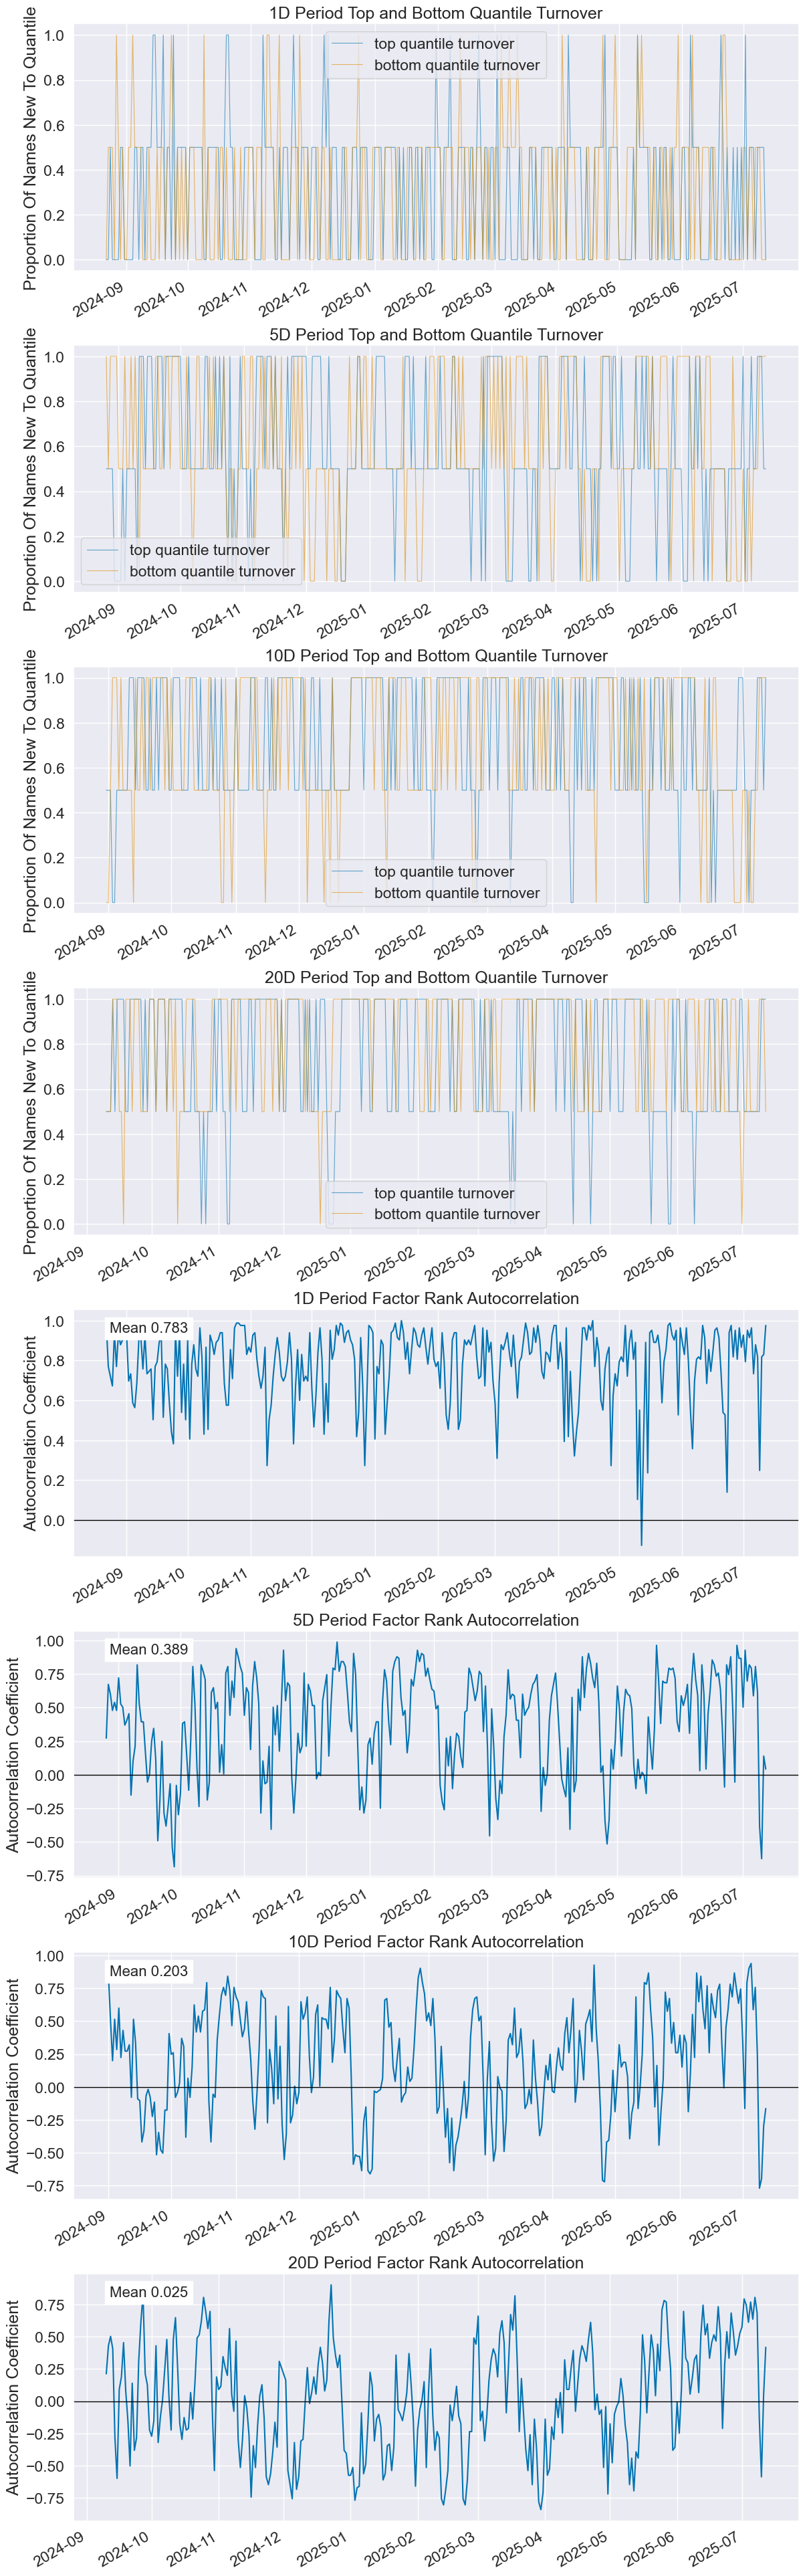

In [8]:
from alphalens.utils import get_clean_factor_and_forward_returns
ret = get_clean_factor_and_forward_returns(factor_series, prices_df, periods=(1, 5, 10, 20), quantiles=5, groupby=None)
alphalens.tears.create_full_tear_sheet(ret)